In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def df_attach_text(path_to_df):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path_to_df)
    
    # Extract the base filename and construct 'run.sequence.string'
    base_name = os.path.basename(path_to_df).split('.')[0:2]  # Get 'xxxx.yyyy'
    run_sequence_string = f"{base_name[0]}\n{base_name[1]}\n\n"
    df['run.sequence.string'] = run_sequence_string
    
    # Find columns before 'C_nr'
    if 'C_nr' in df.columns:
        before_C_nr_columns = list(df.columns[:df.columns.get_loc('C_nr')])
    else:
        before_C_nr_columns = []
    
    df = df.sort_values(by=before_C_nr_columns)

    # Construct 'label'
    def create_label(row):
        label = ""
        for col in before_C_nr_columns:
            formatted_col_name = col.replace("_", "\n") + "\n"
            formatted_value = f"{row[col]:.2g}"  # Format value as :.2g
            label += f"{formatted_col_name}{formatted_value}\n\n"
        return label
    
    if before_C_nr_columns:
        df['label'] = df.apply(create_label, axis=1)
    else:
        df['label'] = ""



    # Drop columns before 'C_nr'
    df = df.drop(columns=before_C_nr_columns)
    
    return df


def process_folder(folder_path):
    # List to store DataFrames
    all_dfs = []
    
    # Iterate over all files in the folder
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith(".csv"):  # Process only CSV files
            file_path = os.path.join(folder_path, file_name)
            # Apply the df_attach_text function to the file
            df = df_attach_text(file_path)
            all_dfs.append(df)
    
    # Concatenate all DataFrames
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    combined_df.to_csv(r'C:\ACME_analysis\multiple_results\combined_df.csv')
    return combined_df

def generate_error_bar_plots(folder_path):
    # Step 1: Process all .csv files in /sequencedf subfolder
    sequencedf_path = os.path.join(folder_path, "sequencedf")
    concatenated_df = process_folder(sequencedf_path)
    
    # Step 2: Identify column types
    type_1_columns = [col for col in concatenated_df.columns if col.startswith('uncertainty_')]
    type_2_columns = [col for col in concatenated_df.columns if col.startswith('scaleduncertainty_')]
    type_3_columns = [
        col for col in concatenated_df.columns 
        if col not in ['run.sequence.string', 'label'] 
        and not col.startswith('uncertainty_') 
        and not col.startswith('scaleduncertainty_')
    ]
    
    # Step 3: Generate plots for each type 3 column
    for col in type_3_columns:
        col_prefix = col.split('_')[0]
        # Skip columns that are not interesting
        #if col_prefix in ['C','omega','phi','tau','A','Am','Ap','zsipm','xsipm','ysipm','N']:
        #    continue
        if col_prefix in ['C','omega','tau','A','Am','Ap','zsipm','xsipm','ysipm','N']:
            continue
        # Extract y values and check for error bars
        y_values = concatenated_df[col]
        uncertainty_col = f'uncertainty_{col}'
        
        # X-axis values and labels
        x_values = range(len(concatenated_df))
        x_labels = concatenated_df['run.sequence.string'] + concatenated_df['label']

        # Create the plot
        plt.figure(figsize=(26, 9))  # Updated figure size
        
        if uncertainty_col in concatenated_df.columns:
            y_errors = concatenated_df[uncertainty_col]
            plt.errorbar(
                x_values, y_values, yerr=y_errors, fmt='o', 
                capsize=5, capthick=3, elinewidth=3, label=col
            )  # Error bars with horizontal caps
        else:
            print(f"Info: No uncertainty column found for {col}. Plotting dots instead.")
            plt.scatter(
                x_values, y_values, s=50, label=col
            )  # Dot plot for values
        
        plt.axhline(0, color='black', linestyle='--', linewidth=3, label='y=0')  # Thick dashed y=0 line
        
        # Add vertical dashed lines to separate different run.sequence.string
        previous_run_seq = None
        for i, run_seq in enumerate(concatenated_df['run.sequence.string']):
            if previous_run_seq and run_seq != previous_run_seq:
                plt.axvline(i - 0.5, color='black', linestyle='--', linewidth=2)
            previous_run_seq = run_seq
        
        # Configure plot aesthetics
        plt.xticks(x_values, x_labels, rotation=0, fontsize=12)  # Smaller font size, horizontal orientation
        plt.ylabel(col, fontsize=12)
        plt.title(col, fontsize=16)
        plt.tight_layout()
        plt.xlim(-0.5, len(concatenated_df) - 0.5)  # Set x-axis limits
        
        # Save the plot to the corresponding folder
        col_prefix = col.split('_')[0]
        col_channel = col.split('_')[1]
        output_dir = os.path.join(folder_path, col_prefix)
        os.makedirs(output_dir, exist_ok=True)
        if col_channel == 'nr':
            colout = col_prefix + '_nonreversing'
        else:
            colout = col_prefix + '_' + col_channel
        output_file = os.path.join(output_dir, f"{colout}.png")
        
        plt.grid(True)
        plt.savefig(output_file)
        plt.close()
        print(f"Plot saved: {output_file}")

In [3]:
folder_path = r"C:\ACME_analysis\multiple_results\acmeii STIRAP slope"
generate_error_bar_plots(folder_path)

Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_nonreversing.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_N.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_E.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_B.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_NE.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_NB.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_EB.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_NEB.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_P.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_NP.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_EP.png
Plot saved: C:\ACME_analysis\multiple_results\acmeii STIRAP slope\phi\phi_BP.png
Plot saved: C:\ACME_a

In [18]:
import os
import glob
import json
import re
import pandas as pd
import plotly.graph_objects as go
from plotly.colors import DEFAULT_PLOTLY_COLORS

def plot_sipm_results(
    folder: str,
    quantities: list,         
    channels: list,           
    sipms: list,              
    condition_of_interest: str
):
    """
    Reads CSV files in folder/sequencesipm_results, creates subfolders for each
    quantity, and plots lines with error bars for 'sipmavg' plus markers for other 
    specified SIPM positions. Skips CSVs that don’t have condition_of_interest.

    Special rule:
      If channels == ["NE","E"], also plot a naive sum (NE+E) and diff (NE-E), 
      but *only* for sipmavg and with *no* error bars.
    """

    # Helper to check if a column is a "sipm data" column or an uncertainty column.
    def is_sipm_column(colname):
        if colname.startswith("uncertainty_"):
            return True
        known_endings = [
            "_sipmavg", "_zplus", "_zminus", "_yplus", "_yminus",
            "_xplus", "_xminus"
        ]
        for suffix in known_endings:
            if colname.endswith(suffix):
                return True
        if re.search(r"_sipm\d+$", colname):
            return True
        return False

    # Read optional labels.json
    labels_path = os.path.join(folder, "labels.json")
    if os.path.isfile(labels_path):
        with open(labels_path, "r", encoding="utf-8") as f:
            labels_dict = json.load(f)
    else:
        labels_dict = {}

    # Create subfolders for each quantity if needed
    for quantity in quantities:
        quantity_folder = os.path.join(folder, quantity)
        os.makedirs(quantity_folder, exist_ok=True)

    # Basic channel -> line style mapping
    predefined_line_styles = ["solid", "dash", "dot", "dashdot", "longdash"]
    channel_line_styles = {
        ch: predefined_line_styles[i % len(predefined_line_styles)]
        for i, ch in enumerate(channels)
    }

    # Marker symbols for sipms
    sipm_markers = {"sipmavg": "circle"}
    non_avg_sipms = [s for s in sipms if s.lower() != "sipmavg"]
    extra_symbols = ["square-open", "star", "triangle-up", "triangle-down", "x"]
    for i, s in enumerate(non_avg_sipms):
        sipm_markers[s] = extra_symbols[i % len(extra_symbols)]

    # Gather CSV files
    results_path = os.path.join(folder, "sequencesipm_results", "*.csv")
    csv_files = sorted(glob.glob(results_path))

    # Decide if we do naive sum/diff (only if channels == ["NE", "E"])
    do_sum_diff = (sorted(channels) == ["E", "NE"])
    #do_sum_diff = False
    # We can define styles for sum/diff if desired:
    sum_line_style = "dot"
    diff_line_style = "dashdot"

    # Start plotting loop
    for quantity in quantities:
        fig = go.Figure()
        color_map = {}
        color_index = 0

        def get_next_color():
            nonlocal color_index
            c = DEFAULT_PLOTLY_COLORS[color_index % len(DEFAULT_PLOTLY_COLORS)]
            color_index += 1
            return c

        for csv_file in csv_files:
            df = pd.read_csv(csv_file)

            # Skip if condition_of_interest not in columns
            if condition_of_interest not in df.columns:
                continue

            # Identify "other condition" columns
            possible_conds = []
            for col in df.columns:
                if col == condition_of_interest:
                    continue
                if is_sipm_column(col):
                    continue
                if col.startswith(f"{quantity}_") or col.startswith(f"uncertainty_{quantity}_"):
                    continue
                possible_conds.append(col)

            # If no other conditions, treat the entire DF as one group
            if len(possible_conds) == 0:
                grouped = [([], df)]
            else:
                grouped = df.groupby(possible_conds)

            # Build base label from filename + optional label from labels.json
            base_name = os.path.splitext(os.path.basename(csv_file))[0]  # e.g. "0009.0007"
            extra_label = labels_dict.get(base_name, "")
            extra_label_str = f" {extra_label}" if extra_label else ""

            for group_vals, subdf in grouped:
                if not isinstance(group_vals, tuple):
                    group_vals = (group_vals,)

                # Build "other condition" label snippet, e.g. " temp=0.12, press=17"
                other_conds_parts = []
                for ccol, cval in zip(possible_conds, group_vals):
                    if pd.api.types.is_numeric_dtype(df[ccol]):
                        val_str = f"{cval:.6g}"
                    else:
                        val_str = str(cval)
                    other_conds_parts.append(f"{ccol}={val_str}")
                other_cond_label = (" " + ", ".join(other_conds_parts)) if other_conds_parts else ""

                # Combine into final label prefix
                line_label_prefix = f"{base_name}{extra_label_str}{other_cond_label}"

                # get unique color
                color_key = str((base_name, group_vals))
                if color_key not in color_map:
                    color_map[color_key] = get_next_color()
                color_for_this_combo = color_map[color_key]

                # Sort by condition_of_interest
                subdf_sorted = subdf.sort_values(by=condition_of_interest)

                # ---- 1) Plot standard channels: NE, E, etc. ----
                for ch in channels:
                    main_colname = f"{quantity}_{ch}_sipmavg"
                    if main_colname not in subdf_sorted.columns:
                        continue

                    x_main = subdf_sorted[condition_of_interest].values
                    y_main = subdf_sorted[main_colname].values

                    # uncertainty column for sipmavg
                    unc_colname = f"uncertainty_{quantity}_{ch}_sipmavg"
                    if unc_colname in subdf_sorted.columns:
                        y_err = subdf_sorted[unc_colname].values
                    else:
                        y_err = None

                    # Plot main line (sipmavg)
                    fig.add_trace(
                        go.Scatter(
                            x=x_main,
                            y=y_main,
                            error_y=dict(
                                type='data',
                                array=y_err if y_err is not None else None,
                                visible=(y_err is not None),
                                symmetric=True,
                                thickness=1.0,
                                width=4,
                            ),
                            mode="lines+markers",
                            line=dict(color=color_for_this_combo,
                                      dash=channel_line_styles.get(ch, "solid")),
                            marker=dict(symbol=sipm_markers["sipmavg"], color=color_for_this_combo),
                            name=f"{line_label_prefix} [{ch}]",
                            showlegend=True
                        )
                    )

                    # Additional sipms: marker-only
                    for s in non_avg_sipms:
                        colname_sipm = f"{quantity}_{ch}_{s}"
                        if colname_sipm not in subdf_sorted.columns:
                            continue
                        x_sipm = subdf_sorted[condition_of_interest].values
                        y_sipm = subdf_sorted[colname_sipm].values

                        fig.add_trace(
                            go.Scatter(
                                x=x_sipm,
                                y=y_sipm,
                                mode="markers",
                                marker=dict(symbol=sipm_markers[s],
                                            color=color_for_this_combo,
                                            size=8),
                                name=f"{line_label_prefix} [{ch}, {s}]",
                                showlegend=True
                            )
                        )

                # ---- 2) If channels == ["NE","E"], also plot sum (NE+E) & diff (NE-E) ----
                if do_sum_diff:
                    # We'll do naive sum/diff ONLY for sipmavg, no error bars
                    col_NE = f"{quantity}_NE_sipmavg"
                    col_E  = f"{quantity}_E_sipmavg"
                    if col_NE in subdf_sorted.columns and col_E in subdf_sorted.columns:
                        x_values = subdf_sorted[condition_of_interest].values
                        y_NE = subdf_sorted[col_NE].values
                        y_E  = subdf_sorted[col_E].values

                        y_sum = y_NE + y_E
                        y_diff = y_NE - y_E

                        # 2a) Plot sum
                        fig.add_trace(
                            go.Scatter(
                                x=x_values,
                                y=y_sum,
                                # No error bars
                                mode="lines+markers",
                                line=dict(color=color_for_this_combo, dash=sum_line_style),
                                marker=dict(symbol=sipm_markers["sipmavg"], 
                                            color=color_for_this_combo,
                                            size=8),
                                name=f"{line_label_prefix} [NE+E, sipmavg]",
                                showlegend=True
                            )
                        )

                        # 2b) Plot diff
                        fig.add_trace(
                            go.Scatter(
                                x=x_values,
                                y=y_diff,
                                # No error bars
                                mode="lines+markers",
                                line=dict(color=color_for_this_combo, dash=diff_line_style),
                                marker=dict(symbol=sipm_markers["sipmavg"], 
                                            color=color_for_this_combo,
                                            size=8),
                                name=f"{line_label_prefix} [NE-E, sipmavg]",
                                showlegend=True
                            )
                        )

        # After processing all CSVs for this quantity, save
        channels_str = ",".join(channels)
        purged_condition_of_interest = condition_of_interest.replace("/", "_")
        out_name = f"{quantity}_{channels_str}_vs_{purged_condition_of_interest}.html"
        out_path = os.path.join(folder, quantity, out_name)
        fig.update_layout(
            title=f"{quantity} vs. {condition_of_interest} ({channels_str})",
            xaxis_title=condition_of_interest,
            yaxis_title=quantity,
            legend=dict(font=dict(size=20), orientation="v"),
        )
        fig.write_html(out_path, auto_open=False)

    print("Done! HTML plots saved under each quantity’s subfolder.")

In [28]:
plot_sipm_results(
    folder = r"C:\ACME_analysis\multiple_results\Enrnoise_D",
    quantities = ["phi"],         # e.g. ["phi", "C"]
    channels = ["NEB"],       # e.g. ["NE", "E"]
    sipms = ["sipmavg"],           # e.g. ["sipmavg", "zplus", "zminus", ...]
    condition_of_interest = "D"
)

Done! HTML plots saved under each quantity’s subfolder.


In [6]:
import os
import pandas as pd
import numpy as np

# Function to compute the slope of y vs x
def compute_slope(x, y):
    if len(x) > 1 and len(y) > 1:
        coeffs = np.polyfit(x, y, 1)  # Linear regression, return slope
        return coeffs[0]
    else:
        return np.nan

def process_csv_files(folder_path):
    all_files = [
        os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')
    ]

    combined_df = pd.DataFrame()
    results = []

    for file in all_files:
        df = pd.read_csv(file)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Rename columns
    combined_df.rename(columns={
        'Vertical_STIRAP_one_photon_nr': 'Delta',
        'Vertical_STIRAP_two_photon_nr': 'delta'
    }, inplace=True)

    # Group by Delta and delta, compute slopes
    grouped = combined_df.groupby(['Delta', 'delta'])
    for (Delta, delta), group in grouped:
        phi_NE_slope = compute_slope(
            group['STIRAP_690_half_wave_angle'], group['phi_NE_sipmavg']
        )
        phi_E_slope = compute_slope(
            group['STIRAP_690_half_wave_angle'], group['phi_E_sipmavg']
        )
        results.append({
            'Delta': Delta,
            'delta': delta,
            'phi_NE_slope': phi_NE_slope,
            'phi_E_slope': phi_E_slope
        })

    # Create dataframes for output
    result_df = pd.DataFrame(results)
    combined_df.to_csv(os.path.join(folder_path, 'combined.csv'), index=False)
    result_df.to_csv(os.path.join(folder_path, 'result.csv'), index=False)

    print(f"Combined data saved to 'combined.csv' and results saved to 'result.csv' in folder: {folder_path}")

# Example usage
folder_path = r"C:\ACME_analysis\multiple_results\STIRAP\One or Two photon in Brendon Convention\2E" # Replace with your folder path
process_csv_files(folder_path)


Combined data saved to 'combined.csv' and results saved to 'result.csv' in folder: C:\ACME_analysis\multiple_results\STIRAP\One or Two photon in Brendon Convention\2E


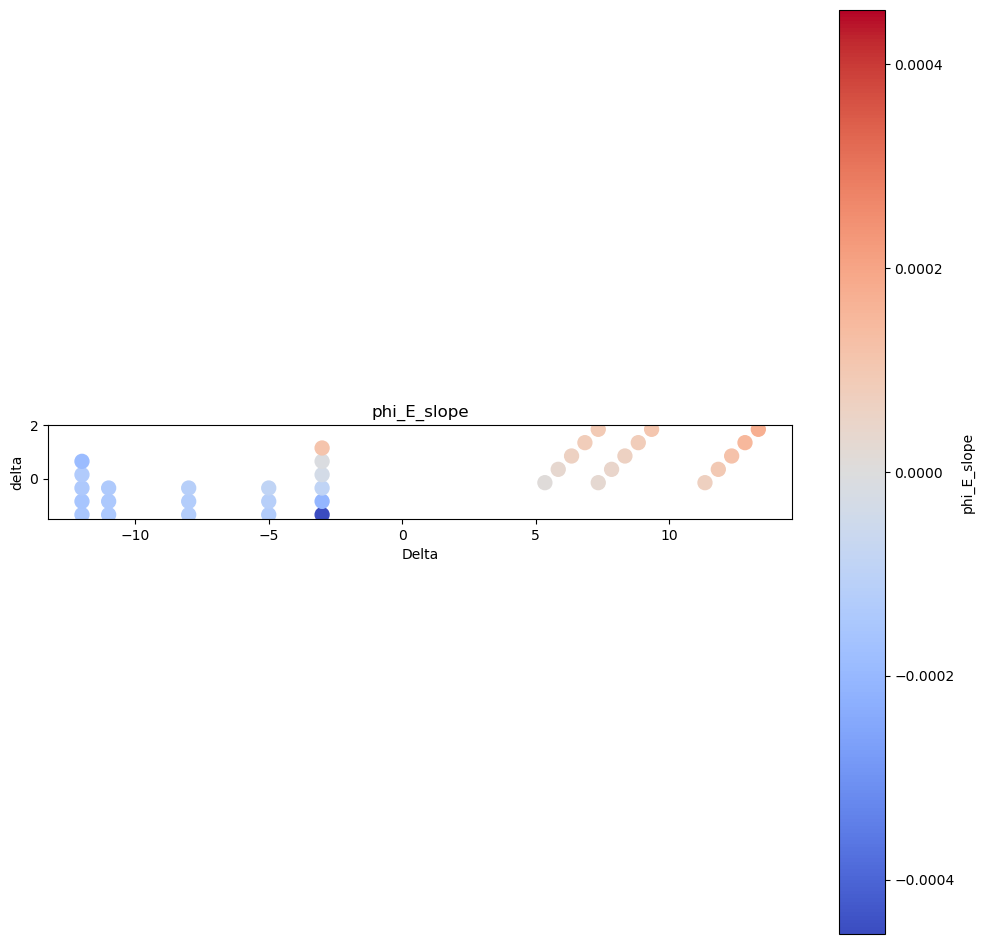

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_heatmap(df, x_col, y_col, data_col):
    # Get the range of data_col to define the color scale
    vmin = df[data_col].min()
    vmax = df[data_col].max()
    max_abs = max(abs(vmin), abs(vmax))

    # Create the scatter plot
    plt.figure(figsize=(12, 12))
    scatter = plt.scatter(
        df[x_col],
        df[y_col],
        c=df[data_col],
        s = 100,
        cmap='coolwarm',
        vmin=-max_abs,
        vmax=max_abs
    )

    # Add a color bar centered at zero
    cbar = plt.colorbar(scatter)
    cbar.set_label(data_col)

    # Set axis labels and title
    plt.title('phi_E_slope')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    # Ensure equal aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    # Show the plot
    plt.show()

# Example usage:
# df = pd.DataFrame({
#     'x': [-5, -3, 0, 3, 5],
#     'y': [-5, -2, 0, 2, 5],
#     'data': [0.1, -0.3, 0.0, 0.5, -0.1]
# })

df = pd.read_csv(r"C:\ACME_analysis\multiple_results\STIRAP\One or Two photon in Brendon Convention\slope results\two_photon_detuning.csv")
plot_scatter_heatmap(df, 'Delta', 'delta', 'phi_E_slope')